In [1]:
from __future__ import print_function, division
import os, bz2, json, time
from datetime import timedelta

import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import my_util

In [2]:
dataset_base = "G:/MLCV dataset/engagement'16/tweeted_videos" 
# dataset_base = "G:/MLCV dataset/engagement'16/quality_videos"
test_category = "music"
# test_category = "movies"
# test_category = "vevo"

categories = ["activism","autos","comedy","education","entertainment", \
              "film","gaming","howto","movies","music","news","people", \
              "pets","science","shows","sports","trailers","travel"]

with open(os.path.join(dataset_base, test_category+".json"), "r") as f:
    dataset_json = f.readlines()

#### Preprocess dataset

In [3]:
eval_days = [90, 135, 180, 225, 270]

In [4]:
# dict-like dataset
dataset = {}
# attributes
vids_set = set()
vids = []
days = []
views = []
shares = []
watches = []
for line in dataset_json:
    record = json.loads(line)
    try:
        category_id = int(record['snippet']['categoryId'])
        day = [int(x) for x in record['insights']['days'].split(",")]
        """!!!"""
        if len(day) < eval_days[-1]: continue
        """!!!"""
        view = [int(x) for x in record['insights']['dailyView'].split(",")]
        share = [int(x) for x in record['insights']['dailyShare'].split(",")]
        watch = [float(x) for x in record['insights']['dailyWatch'].split(",")]
    except:
        continue
    dataset[record['id']] = (category_id, day, view, share, watch)
    
    if record['id'] in vids_set:
        continue
    vids_set.add(record['id'])
    
    vids.append(record['id'])
    days.append(day)
    views.append(view)
    shares.append(share)
    watches.append(watch)
print("dataset size:", len(vids))

dataset size: 116884


#### Stats

In [5]:
print("Min days",np.min([len(x) for x in days]))
print("Max days",np.max([len(x) for x in days]))
print("Average days",np.average([len(x) for x in days]))

Min days 270
Max days 328
Average days 290.44100133465656


#### Analysis

In [6]:
df_total_views = my_util.total_at(eval_days, views, vids, accumulate=False)
# pop_percs = my_util.pop_perc_at(eval_days[:2], views, vids, accumulate=False)
# _, popPerc_eval = my_util.plot_popPerc_totalViews(eval_days, df_total_views, pop_percs)

In [7]:
# my_util.plot_popPerc_totalViews_Tvs2T(eval_days, popPerc_eval)

In [8]:
def total_log_at(days, series, vids, accumulate=True):
    """ compute total number of a series(views/shares...) at several evaluation days
    :return: a dataframe
    :param accumulate: when false, sum from last day to current day
    """
    series_eval = []
    for i in range(len(series)):
        if accumulate:
            series_accu = [np.sum(series[i][:day]) for day in days]
        else:
            series_accu = []
            for j in range(len(days)):
                if j==0: series_accu.append(math.log(max(np.sum(series[i][:days[j]]),1), 10))
                else: series_accu.append(math.log(max(np.sum(series[i][days[j-1]:days[j]]), 1), 10))        
        series_eval.append(series_accu)
    
    df_series_eval = pd.DataFrame(series_eval, columns =days, index = vids)
    return df_series_eval

In [9]:
df_total_views_log = total_log_at(eval_days, views, vids, accumulate=False)

In [10]:
def plot_fixed_window(days, df):    
    data = [dict() for x in days[1:]]
    index = df.index
    
    for i in index:
        for j, d in enumerate(days[1:]):
            short_term = "{:.1f}".format(df.loc[i, days[0]])
#             if short_term == '7.9': print(i)
            if short_term not in data[j]:
                data[j][short_term]=[]   
            data[j][short_term].append(df.loc[i, d])
                                     
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    for j in range(len(data)):
        xs = [float(x) for x in list(data[j].keys())]
        xs.sort()
        ys = [np.mean(data[j][str(x)]) for x in xs]
        ax.plot(xs, ys)
#         if j == 1:
#             print(xs[-5:])
#             print([data[j][str(x)] for x in xs][-5:])
    ax.set_ylabel("Long-term average daily views(log)", color="blue")
    ax.set_xlabel("Short-term average daily views(log)", color="blue")    

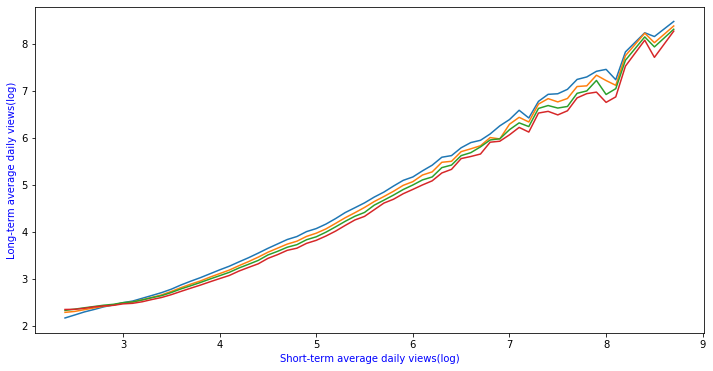

In [11]:
plot_fixed_window(eval_days, df_total_views_log)

In [12]:
df_total_views.head()

,90,135,180,225,270
WqBLeWiUiek,67338,3066,2107,2927,2988
h3ap5dOT8l0,3835,1087,896,762,660
ejxl8xUYyIU,1243,198,124,133,147
aIsXGrFkpBo,2196,568,692,419,531
ppDudShVWP4,20383,2593,2172,1609,753


In [15]:
# dataset["8s_TrrIzA1I"]